<a href="https://colab.research.google.com/github/ravikshaga/ERAV2/blob/main/S8/ERAV2_S8_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision

In [3]:
print('==> Preparing data..')
batch_size = 128
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')



==> Preparing data..


100%|██████████| 170498071/170498071 [00:02<00:00, 57766192.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.2023, 1/0.1994, 1/0.2010 ]),
                                transforms.Normalize(mean = [ -0.4914, -0.4822, -0.4465 ],
                                                     std = [ 1., 1., 1. ]),
                               ])


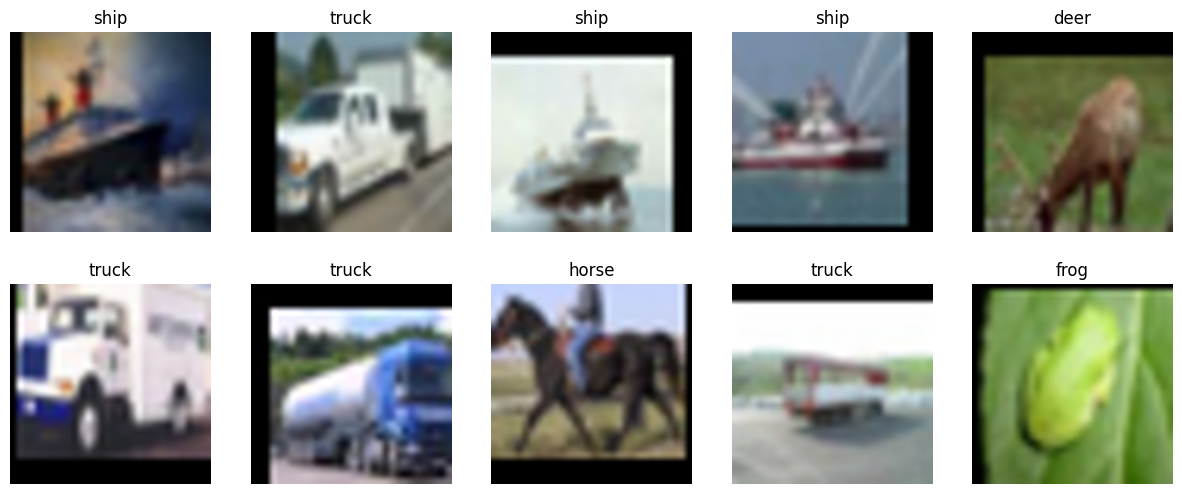

In [5]:
curr_data = next(iter(trainloader))
cifar10_to_plot = curr_data[0][:10,:,:,:]
cifar10_to_plot_labels = curr_data[1]
# print(cifar10_to_plot_labels)
import matplotlib.pyplot as plt
#Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(15,6))
for r in range(2):
    for c in range(5):
        img =cifar10_to_plot[2*c+r]
        axes1[r][c].set_axis_off()
        axes1[r][c].title.set_text(classes[cifar10_to_plot_labels[2*c+r]])
        axes1[r][c].imshow(transforms.ToPILImage()(invTrans(img)), interpolation='spline16')

In [6]:
# Make this network:
# C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11
# cN is 1x1 Layer
# Keep the parameter count less than 50000
# Max Epochs is 20

In [17]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # C1, input size: 32, in_channels = 3, jin = 1
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # out = 32 , jout = 1, rf = 3

        # C2, in = 32, jin = 1
        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # out = 32 , jout = 1, rf = 5

        # c3, in = 32, jin = 1
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # out = 32, jout = 1, rf = 5

        # TRANSITION BLOCK, MaxPool P1
        self.P1 = nn.MaxPool2d(2, 2) # output_size = 16, jout = 2, rf = 6

        # C4, in = 16, jin = 2
        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # out = 16, jout = 2, rf = 10

        # C5, in = 16, jin = 2
        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # out = 16, jout = 2, rf = 14

        # C6, in = 16, jin = 2
        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # out = 16, jout = 2, rf = 18

        # c7, in = 16, jin = 2
        self.c7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # out = 16, jout = 2, rf = 18

        # TRANSITION BLOCK, MaxPool P2
        self.P2 = nn.MaxPool2d(2, 2) # output_size = 8, rf = 20

        # C8, in = 8, jin = 4
        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # out = 8, jout = 4, rf = 28

        # C9, in = 8, jin = 4
        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # out = 8, jout = 4, rf = 36

        # C10, in = 8, jin = 4
        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=28, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(28),
            nn.Dropout(dropout_value)
        ) # out = 8, jout = 4, rf = 44

        self.GAP = nn.Sequential(
            nn.AvgPool2d(kernel_size=8) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # out = 1

        # c11, input size:
        self.c11 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU(),
            # nn.BatchNorm2d(10),
            # nn.Dropout(dropout_value)
        ) # out = , rf =

    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)
        x = self.c3(x)
        x = self.P1(x)
        x = self.C4(x)
        x = self.C5(x)
        x = self.C6(x)
        x = self.c7(x)
        x = self.P2(x)
        x = self.C8(x)
        x = self.C9(x)
        x = self.C10(x)
        x = self.GAP(x)
        x = self.c11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [18]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]           2,048
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 16,

In [20]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [22]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    scheduler.step()


EPOCH: 0


Loss=1.9342981576919556 Batch_id=1562 Accuracy=34.87: 100%|██████████| 1563/1563 [00:39<00:00, 39.51it/s]



Test set: Average loss: 1.5801, Accuracy: 4003/10000 (40.03%)

EPOCH: 1


Loss=1.2653802633285522 Batch_id=1562 Accuracy=49.93: 100%|██████████| 1563/1563 [00:40<00:00, 38.71it/s]



Test set: Average loss: 1.2257, Accuracy: 5644/10000 (56.44%)

EPOCH: 2


Loss=0.9025219082832336 Batch_id=1562 Accuracy=55.89: 100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]



Test set: Average loss: 1.2988, Accuracy: 5278/10000 (52.78%)

EPOCH: 3


Loss=1.1838929653167725 Batch_id=1562 Accuracy=59.25: 100%|██████████| 1563/1563 [00:39<00:00, 39.10it/s]



Test set: Average loss: 1.0993, Accuracy: 5946/10000 (59.46%)

EPOCH: 4


Loss=0.9881823062896729 Batch_id=1562 Accuracy=61.88: 100%|██████████| 1563/1563 [00:40<00:00, 38.55it/s]



Test set: Average loss: 1.0901, Accuracy: 6085/10000 (60.85%)

EPOCH: 5


Loss=1.2451441287994385 Batch_id=1562 Accuracy=64.09: 100%|██████████| 1563/1563 [00:40<00:00, 38.29it/s]



Test set: Average loss: 0.9203, Accuracy: 6613/10000 (66.13%)

EPOCH: 6


Loss=0.7584595680236816 Batch_id=1562 Accuracy=69.02: 100%|██████████| 1563/1563 [00:42<00:00, 36.41it/s]



Test set: Average loss: 0.8192, Accuracy: 7113/10000 (71.13%)

EPOCH: 7


Loss=1.0598047971725464 Batch_id=1562 Accuracy=69.90: 100%|██████████| 1563/1563 [00:40<00:00, 38.29it/s]



Test set: Average loss: 0.7923, Accuracy: 7215/10000 (72.15%)

EPOCH: 8


Loss=1.0301507711410522 Batch_id=1562 Accuracy=70.26: 100%|██████████| 1563/1563 [00:39<00:00, 39.19it/s]



Test set: Average loss: 0.7782, Accuracy: 7249/10000 (72.49%)

EPOCH: 9


Loss=1.0102558135986328 Batch_id=1562 Accuracy=70.86: 100%|██████████| 1563/1563 [00:39<00:00, 39.62it/s]



Test set: Average loss: 0.7717, Accuracy: 7294/10000 (72.94%)

EPOCH: 10


Loss=0.9691209197044373 Batch_id=1562 Accuracy=70.97: 100%|██████████| 1563/1563 [00:38<00:00, 40.09it/s]



Test set: Average loss: 0.7615, Accuracy: 7294/10000 (72.94%)

EPOCH: 11


Loss=0.5792276859283447 Batch_id=1562 Accuracy=71.22: 100%|██████████| 1563/1563 [00:38<00:00, 40.14it/s]



Test set: Average loss: 0.7741, Accuracy: 7265/10000 (72.65%)

EPOCH: 12


Loss=1.054481863975525 Batch_id=1562 Accuracy=71.85: 100%|██████████| 1563/1563 [00:38<00:00, 40.40it/s]



Test set: Average loss: 0.7737, Accuracy: 7284/10000 (72.84%)

EPOCH: 13


Loss=1.0456796884536743 Batch_id=1562 Accuracy=71.92: 100%|██████████| 1563/1563 [00:39<00:00, 40.05it/s]



Test set: Average loss: 0.7543, Accuracy: 7319/10000 (73.19%)

EPOCH: 14


Loss=0.814912736415863 Batch_id=1562 Accuracy=71.96: 100%|██████████| 1563/1563 [00:39<00:00, 39.81it/s]



Test set: Average loss: 0.7504, Accuracy: 7340/10000 (73.40%)

EPOCH: 15


Loss=0.6939705610275269 Batch_id=1562 Accuracy=71.93: 100%|██████████| 1563/1563 [00:38<00:00, 40.19it/s]



Test set: Average loss: 0.7579, Accuracy: 7336/10000 (73.36%)

EPOCH: 16


Loss=1.0020945072174072 Batch_id=1562 Accuracy=72.23: 100%|██████████| 1563/1563 [00:38<00:00, 40.34it/s]



Test set: Average loss: 0.7591, Accuracy: 7291/10000 (72.91%)

EPOCH: 17


Loss=1.2781933546066284 Batch_id=1562 Accuracy=72.04: 100%|██████████| 1563/1563 [00:39<00:00, 39.95it/s]



Test set: Average loss: 0.7482, Accuracy: 7362/10000 (73.62%)

EPOCH: 18


Loss=0.743468701839447 Batch_id=1562 Accuracy=72.32: 100%|██████████| 1563/1563 [00:39<00:00, 39.87it/s]



Test set: Average loss: 0.7503, Accuracy: 7360/10000 (73.60%)

EPOCH: 19


Loss=0.6646955609321594 Batch_id=1562 Accuracy=72.26: 100%|██████████| 1563/1563 [00:38<00:00, 40.26it/s]



Test set: Average loss: 0.7532, Accuracy: 7348/10000 (73.48%)



Text(0.5, 1.0, 'Test Accuracy')

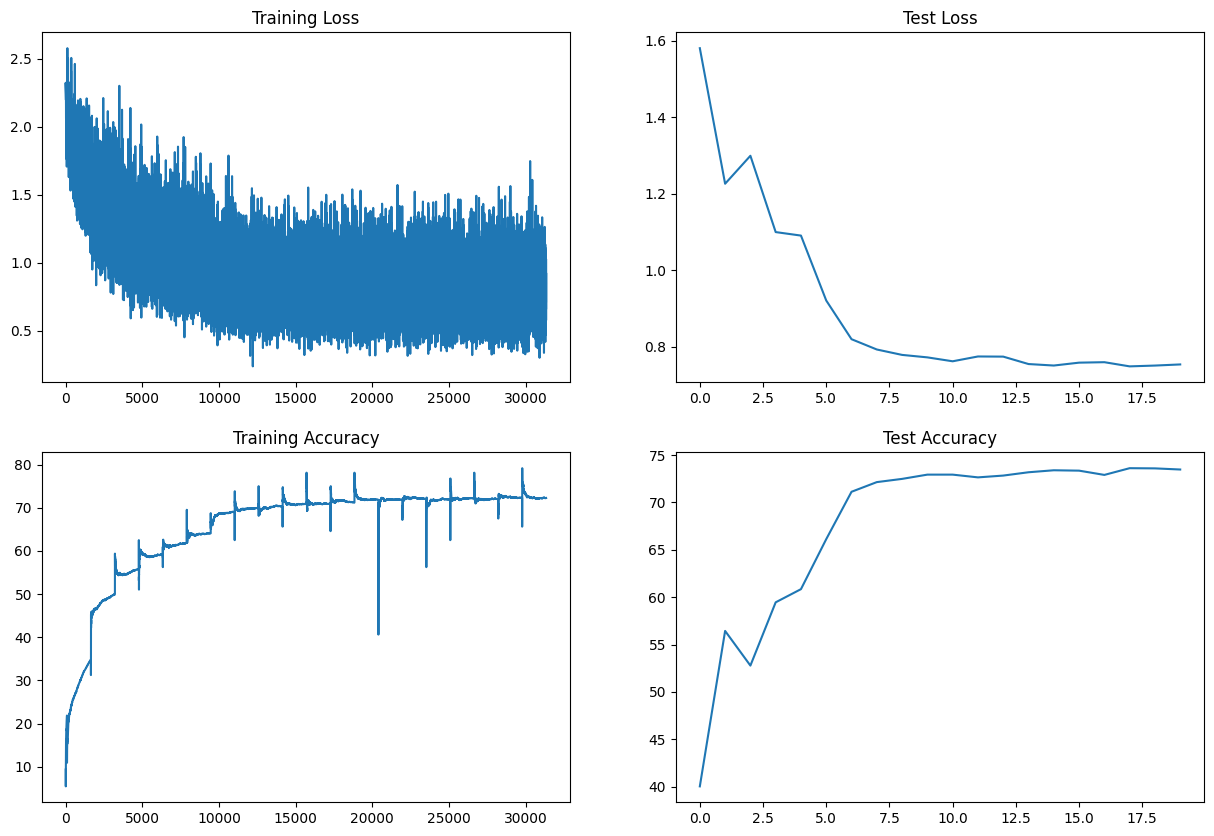

In [37]:
def conv_to_list(inp):
  return [x.detach().cpu().item() for x in inp]

# print(conv_to_list(train_losses))
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(conv_to_list(train_losses))
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")


In [ ]:
print('==> Preparing data..')
batch_size = 128

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)



28


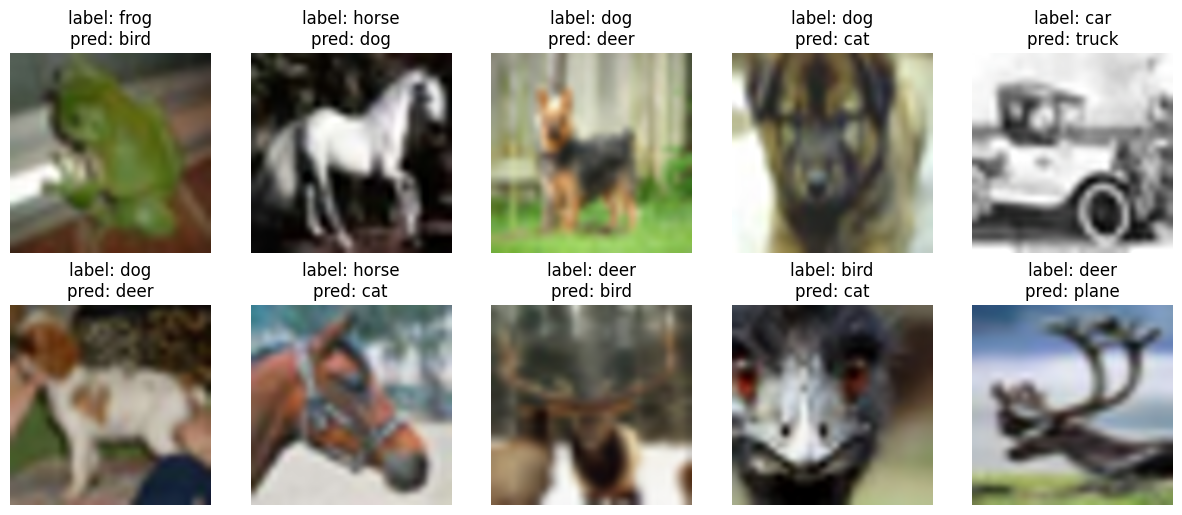

In [53]:

model.eval()
N_incorrect = 10
count = 0
with torch.no_grad():

    for data, target in testloader:
        while count < N_incorrect:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_not_correct = pred.ne(target.view_as(pred))
            # print(is_not_correct)
            incorrect_pred_data = data[torch.squeeze(is_not_correct)]
            incorrect_pred_orig_labels = target[torch.squeeze(is_not_correct)]
            incorrect_pred_labels = torch.squeeze(pred[torch.squeeze(is_not_correct)])
            count += pred.ne(target.view_as(pred)).sum().item()
            print(count)



# print(pred.shape, target.shape, incorrect_pred_data.shape, incorrect_pred_orig_labels.shape, incorrect_pred_labels.shape)
cifar10_to_plot = incorrect_pred_data[:10,:,:,:]
cifar10_to_plot_orig_labels = incorrect_pred_orig_labels[:10]
cifar10_to_plot_pred_labels = incorrect_pred_labels[:10]
# print(cifar10_to_plot_labels)
import matplotlib.pyplot as plt
#Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(15,6))
for r in range(2):
    for c in range(5):
        img =cifar10_to_plot[2*c+r]
        axes1[r][c].set_axis_off()
        text = "label: " + str(classes[cifar10_to_plot_orig_labels[2*c+r]]) + '\n'
        text +=  "pred: " + str(classes[cifar10_to_plot_pred_labels[2*c+r]])
        axes1[r][c].title.set_text(text)
        axes1[r][c].imshow(transforms.ToPILImage()(invTrans(img)), interpolation='spline16')
